In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from sklearn import ensemble
from sklearn import metrics

fatal_police_shooting_us = pd.read_csv('/content/drive/My Drive/data/cleaned-data/cleaned-PoliceKillingsUS.csv', encoding="windows-1252")
demographic = pd.read_csv('/content/drive/My Drive/data/cleaned-data/demographic.csv', encoding="windows-1252")
data = pd.read_csv('/content/drive/My Drive/data/cleaned-data/combined.csv', encoding="windows-1252")

In [ ]:
print('--fatal_police_shooting_us')
print('Length: {}'.format(len(fatal_police_shooting_us)))
print('--demographic')
print('Length: {}'.format(len(demographic)))
print('--data')
print('Before: {}'.format(len(data)))
data = data.dropna(axis=0)
print('After:  {}'.format(len(data)))

--fatal_police_shooting_us
Length: 2254
--demographic
Length: 29132
--data
Before: 29969
After:  1938


In [ ]:
data.head()

,state,city,percent_completed_hs,poverty_rate,Median Income,share_white,share_black,share_native_american,share_asian,share_hispanic,id,name,date,manner_of_death,armed,age,gender,race,signs_of_mental_illness,threat_level,flee,body_camera
25,AK,Barrow,84.6,11.7,76902.0,16.9,1.0,61.2,9.1,3.1,1255.0,Vincent Nageak,10/02/16,shot,gun,36.0,M,N,False,attack,Not fleeing,False
32,AK,Big Lake,90.4,9.6,70988.0,86.1,0.2,7.0,0.5,3.1,2363.0,Jean R. Valescot,17/02/17,shot,gun,35.0,M,B,False,attack,Not fleeing,False
89,AK,Fairbanks,91.2,13.1,55229.0,66.1,9.0,10.0,3.6,9.0,836.0,Tristan Vent,08/09/15,shot,gun,19.0,M,N,False,attack,Not fleeing,False
90,AK,Fairbanks,91.2,13.1,55229.0,66.1,9.0,10.0,3.6,9.0,816.0,Vincent J. Perdue,09/09/15,shot,gun,33.0,M,N,False,attack,Car,False
91,AK,Fairbanks,91.2,13.1,55229.0,66.1,9.0,10.0,3.6,9.0,2618.0,Shawn Buck,25/05/17,shot,gun,23.0,M,W,False,attack,Car,False


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1938 entries, 25 to 29882
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   state                    1938 non-null   object 
 1   city                     1938 non-null   object 
 2   percent_completed_hs     1938 non-null   float64
 3   poverty_rate             1938 non-null   float64
 4   Median Income            1938 non-null   float64
 5   share_white              1938 non-null   float64
 6   share_black              1938 non-null   float64
 7   share_native_american    1938 non-null   float64
 8   share_asian              1938 non-null   float64
 9   share_hispanic           1938 non-null   float64
 10  id                       1938 non-null   float64
 11  name                     1938 non-null   object 
 12  date                     1938 non-null   object 
 13  manner_of_death          1938 non-null   object 
 14  armed                 

# **Predict age of victims**

In [ ]:
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import inspection
from sklearn import metrics

FEATURE_AGE = ['percent_completed_hs','poverty_rate','Median Income',
               'share_white','share_black','share_asian',
               'share_native_american','share_hispanic','manner_of_death', 
               'armed', 'gender', 'race', 'signs_of_mental_illness', 
               'threat_level']
TARGET_AGE = 'age'

X_age = data[FEATURE_AGE]
y_age = data[TARGET_AGE]

In [ ]:
object_cols = (X_age.dtypes == 'object')[X_age.dtypes == 'object'].index
X_age[object_cols].describe()

OH_FEATURES = ['race', 'threat_level', 'armed']  # since these variables are nominal
LABEL_FEATURES = ['manner_of_death', 'gender', 'signs_of_mental_illness'] # since these are binary variables

,manner_of_death,armed,gender,race,signs_of_mental_illness,threat_level
count,1938,1938,1938,1938,1938,1938
unique,2,58,2,6,2,3
top,shot,gun,M,W,False,attack
freq,1806,1074,1853,965,1457,1251


In [ ]:
# reduce categories in 'armed' column by removing rarely appeared (<=7) values
s = X_age['armed'].value_counts() 
armed_others = list(s[s<=7].index) 
X_age['armed'] = X_age['armed'].apply(lambda x: 'others' if x in armed_others else x)
X_age['armed'].value_counts()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


gun               1074
knife              276
unarmed            148
vehicle            142
others             103
toy weapon          87
undetermined        84
machete             15
unknown weapon       9
Name: armed, dtype: int64

In [ ]:
TRAIN_SIZE = 0.8
TEST_SIZE = 0.2

# splitting train/test
X_age_train, X_age_test, y_age_train, y_age_test  = model_selection.train_test_split(X_age,y_age,train_size=TRAIN_SIZE, test_size=TEST_SIZE, random_state=0)

# One Hot Encoding 
encoder = preprocessing.OneHotEncoder(handle_unknown='ignore', sparse=False)

X_age_OH_train_cols = pd.DataFrame(encoder.fit_transform(X_age_train[OH_FEATURES]))
X_age_OH_test_cols = pd.DataFrame(encoder.transform(X_age_test[OH_FEATURES]))

X_age_train = X_age_train.drop(OH_FEATURES, axis=1)
X_age_test = X_age_test.drop(OH_FEATURES, axis=1)

X_age_OH_train_cols.columns = encoder.get_feature_names()
X_age_OH_test_cols.columns = encoder.get_feature_names()

X_age_OH_train_cols.index = X_age_train.index
X_age_OH_test_cols.index = X_age_test.index

X_age_train = pd.concat([X_age_train, X_age_OH_train_cols], axis=1)
X_age_test = pd.concat([X_age_test, X_age_OH_test_cols], axis=1)

# Label Encoding
encoder = preprocessing.LabelEncoder()

for col in LABEL_FEATURES:
  X_age_train[col] = encoder.fit_transform(X_age_train[col])
  X_age_test[col] = encoder.transform(X_age_test[col])

X_age_train

,percent_completed_hs,poverty_rate,Median Income,share_white,share_black,share_asian,share_native_american,share_hispanic,manner_of_death,gender,signs_of_mental_illness,x0_A,x0_B,x0_H,x0_N,x0_O,x0_W,x1_attack,x1_other,x1_undetermined,x2_gun,x2_knife,x2_machete,x2_others,x2_toy weapon,x2_unarmed,x2_undetermined,x2_unknown weapon,x2_vehicle
18352,94.5,15.7,52179.0,87.4,0.5,1.1,2.8,12.8,0,1,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2532,75.2,29.8,41531.0,49.6,8.3,12.6,1.7,46.9,0,1,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2223,93.4,16.6,54322.0,80.6,4.8,4.3,0.9,11.7,0,1,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3983,86.6,14.0,55831.0,76.6,2.3,3.7,1.3,30.6,0,1,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17926,85.6,13.5,51097.0,77.4,1.9,1.0,1.3,42.5,0,1,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8999,89.4,6.8,41853.0,97.6,0.8,0.3,0.0,1.2,0,1,1,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17023,88.0,16.7,49896.0,73.1,13.7,2.4,0.8,13.1,1,1,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
25643,72.3,10.3,49868.0,79.4,2.1,0.8,0.7,73.7,0,1,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4085,92.9,4.7,76875.0,93.6,0.9,0.6,0.9,6.7,0,1,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Random Forest Regressor
age_rfr = ensemble.RandomForestRegressor()
param_grid = {'n_estimators': [80, 100],
              'max_depth': [20, 25],
              'min_samples_split': [30,40]}

gridsearch_age_rfr = model_selection.GridSearchCV(estimator=age_rfr, 
                                                  param_grid=param_grid,
                                                  cv=5,
                                                  scoring="neg_root_mean_squared_error")
gridsearch_age_rfr.fit(X_age_train, y_age_train)

print('\n\nRandom Forest Regressor CV RMSE: {}'.format(abs(gridsearch_age_rfr.best_score_)))
print('Best parameters: {}'.format(gridsearch_age_rfr.best_params_))
print('Random Forest Regressor Test RMSE: {}'.format(abs(gridsearch_age_rfr.score(X_age_test, y_age_test))))

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo



Random Forest Regressor CV RMSE: 11.990361021424198
Best parameters: {'max_depth': 20, 'min_samples_split': 40, 'n_estimators': 100}
Random Forest Regressor Test RMSE: 12.410137998319486


In [ ]:
# Gradient Boosting Regressor
age_gbr = ensemble.GradientBoostingRegressor()
param_grid = {'n_estimators': [80, 100],
              'max_depth': [20, 25],
              'min_samples_split': [30,40]}

gridsearch_age_gbr = model_selection.GridSearchCV(estimator=age_gbr, 
                                                  param_grid=param_grid,
                                                  cv=5,
                                                  scoring="neg_root_mean_squared_error")
gridsearch_age_gbr.fit(X_age_train, y_age_train)

print('\n\nGradient Boosting Regressor CV RMSE: {}'.format(abs(gridsearch_age_gbr.best_score_)))
print('Best parameters: {}'.format(gridsearch_age_gbr.best_params_))
print('Gradient Boosting Regressor Test RMSE: {}'.format(abs(gridsearch_age_gbr.score(X_age_test, y_age_test))))

GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_no_change=None,
                 



Gradient Boosting Regressor CV RMSE: 13.026527590258656
Best parameters: {'max_depth': 20, 'min_samples_split': 40, 'n_estimators': 80}
Gradient Boosting Regressor Test RMSE: 13.09553194642082


Text(0.5, 1.0, 'Random Forest Regression')

Text(0.5, 1.0, 'Gradient Boosting Regression')

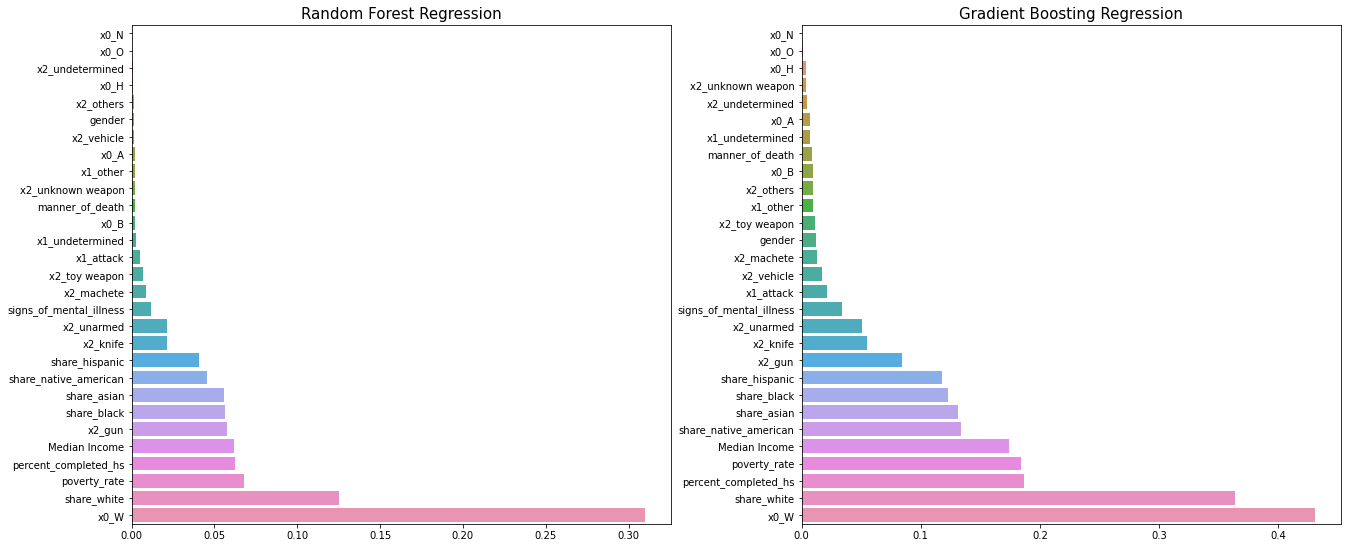

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance

# Random Forest
result = permutation_importance(gridsearch_age_rfr.best_estimator_, X_age_train,
                                y_age_train, n_repeats=10, random_state=0)
age_rfr_feature_importance =  pd.Series(result.importances_mean)
age_rfr_feature_importance.index = X_age_train.columns
age_rfr_feature_importance = age_rfr_feature_importance.sort_values()

# Gradient Boosting
result = permutation_importance(gridsearch_age_gbr.best_estimator_, X_age_train,
                                y_age_train, n_repeats=10, random_state=0)
age_gbr_feature_importance = pd.Series(result.importances_mean)
age_gbr_feature_importance.index = X_age_train.columns
age_gbr_feature_importance = age_gbr_feature_importance.sort_values()

fig, ax = plt.subplots(1,2, figsize=(20,10))
fig.tight_layout(pad=10)
sns.barplot(ax=ax[0],y=age_rfr_feature_importance.index, x=age_rfr_feature_importance)
ax[0].set_title('Random Forest Regression', fontdict={'fontsize': 15})
sns.barplot(ax=ax[1],y=age_gbr_feature_importance.index, x=age_gbr_feature_importance)
ax[1].set_title('Gradient Boosting Regression', fontdict={'fontsize': 15})

Text(0.5, 1.0, 'RMSE between RFR and GBR')

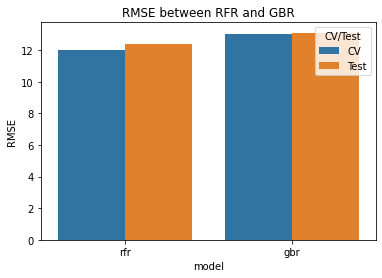

In [ ]:
rfr_CV_RMSE = abs(gridsearch_age_rfr.best_score_)
rfr_test_RMSE = abs(gridsearch_age_rfr.score(X_age_test, y_age_test))
gbr_CV_RMSE = abs(gridsearch_age_gbr.best_score_)
gbr_test_RMSE = abs(gridsearch_age_gbr.score(X_age_test, y_age_test))
age_models = pd.DataFrame({'RMSE': [rfr_CV_RMSE, rfr_test_RMSE, gbr_CV_RMSE, gbr_test_RMSE],
                           'CV/Test':['CV','Test','CV','Test'],
                           'model': ['rfr','rfr','gbr','gbr']})
plt.title('RMSE between RFR and GBR')
sns.barplot(x=age_models['model'], y=age_models['RMSE'], hue=age_models['CV/Test'])

# **Predict race of victims**


In [ ]:
FEATURE_RACE = ['percent_completed_hs','poverty_rate','Median Income',
               'share_white','share_black','share_asian',
               'share_native_american','share_hispanic','manner_of_death', 
               'armed', 'gender', 'age', 'signs_of_mental_illness', 
               'threat_level']
TARGET_RACE = 'race'

X_race = data[FEATURE_RACE]
y_race = data[TARGET_RACE]

In [ ]:
object_cols = (X_race.dtypes == 'object')[X_race.dtypes == 'object'].index
X_race[object_cols].describe()

RACE_OH_FEATURES = ['threat_level', 'armed']  # since these variables are nominal
RACE_LABEL_FEATURES = ['manner_of_death', 'gender', 'signs_of_mental_illness'] # since these are binary variables

,manner_of_death,armed,gender,signs_of_mental_illness,threat_level
count,1938,1938,1938,1938,1938
unique,2,58,2,2,3
top,shot,gun,M,False,attack
freq,1806,1074,1853,1457,1251


In [ ]:
# reduce categories in 'armed' column by removing rarely appeared (<=7) values
s = X_race['armed'].value_counts() 
armed_others = list(s[s<=7].index) 
X_race['armed'] = X_race['armed'].apply(lambda x: 'others' if x in armed_others else x)
X_race['armed'].value_counts()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


gun               1074
knife              276
unarmed            148
vehicle            142
others             103
toy weapon          87
undetermined        84
machete             15
unknown weapon       9
Name: armed, dtype: int64

In [ ]:
TRAIN_SIZE = 0.8
TEST_SIZE = 0.2

# splitting train/test
X_race_train, X_race_test, y_race_train, y_race_test  = model_selection.train_test_split(X_race,y_race,train_size=TRAIN_SIZE, test_size=TEST_SIZE, random_state=0)

# One Hot Encoding 
encoder = preprocessing.OneHotEncoder(handle_unknown='ignore', sparse=False)

X_race_OH_train_cols = pd.DataFrame(encoder.fit_transform(X_race_train[RACE_OH_FEATURES]))
X_race_OH_test_cols = pd.DataFrame(encoder.transform(X_race_test[RACE_OH_FEATURES]))

X_race_train = X_race_train.drop(RACE_OH_FEATURES, axis=1)
X_race_test = X_race_test.drop(RACE_OH_FEATURES, axis=1)

X_race_OH_train_cols.columns = encoder.get_feature_names()
X_race_OH_test_cols.columns = encoder.get_feature_names()

X_race_OH_train_cols.index = X_race_train.index
X_race_OH_test_cols.index = X_race_test.index

X_race_train = pd.concat([X_race_train, X_race_OH_train_cols], axis=1)
X_race_test = pd.concat([X_race_test, X_race_OH_test_cols], axis=1)

# Label Encoding
encoder = preprocessing.LabelEncoder()

for col in RACE_LABEL_FEATURES:
  X_race_train[col] = encoder.fit_transform(X_race_train[col])
  X_race_test[col] = encoder.transform(X_race_test[col])

In [ ]:
# predict race of victims
from sklearn.neighbors import KNeighborsClassifier

race_knn = KNeighborsClassifier()
param_grid = {'n_neighbors': [3, 5, 7, 10, 13]}

gridsearch_race_knn = model_selection.GridSearchCV(estimator=race_knn, 
                                                  param_grid=param_grid,
                                                  cv=5,
                                                  scoring="accuracy")
gridsearch_race_knn.fit(X_race_train, y_race_train)

print('\n\nK Nearest Neighbors CV Accuracy Score: {}'.format(abs(gridsearch_race_knn.best_score_)))
print('Best parameters: {}'.format(gridsearch_race_knn.best_params_))

test_prediction = gridsearch_race_knn.predict(X_race_test)
print('K Nearest Neighbors Test Accuracy Score: {}'.format(metrics.accuracy_score(test_prediction, y_race_test)))
print(metrics.classification_report(y_race_test, test_prediction))

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [3, 5, 7, 10, 13]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)



K Nearest Neighbors CV Accuracy Score: 0.49806451612903224
Best parameters: {'n_neighbors': 7}
K Nearest Neighbors Test Accuracy Score: 0.5
              precision    recall  f1-score   support

           A       0.33      0.10      0.15        10
           B       0.41      0.46      0.43       102
           H       0.37      0.34      0.35        65
           N       0.00      0.00      0.00         8
           O       0.00      0.00      0.00         6
           W       0.59      0.63      0.61       197

    accuracy                           0.50       388
   macro avg       0.28      0.25      0.26       388
weighted avg       0.48      0.50      0.49       388



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# predict race of victims
race_abc = ensemble.AdaBoostClassifier()
param_grid = {'n_estimators': [40, 50, 60]}

gridsearch_race_abc = model_selection.GridSearchCV(estimator=race_abc, 
                                                  param_grid=param_grid,
                                                  cv=5,
                                                  scoring="accuracy")
gridsearch_race_abc.fit(X_race_train, y_race_train)

print('\n\nADA Boost CV Accuracy Score: {}'.format(abs(gridsearch_race_abc.best_score_)))
print('Best parameters: {}'.format(gridsearch_race_abc.best_params_))

test_prediction = gridsearch_race_abc.predict(X_race_test)
print('ADA Boost Test Accuracy Score: {}'.format(metrics.accuracy_score(y_race_test, test_prediction)))
print(metrics.classification_report(y_race_test, test_prediction))

GridSearchCV(cv=5, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=None,
                                          learning_rate=1.0, n_estimators=50,
                                          random_state=None),
             iid='deprecated', n_jobs=None,
             param_grid={'n_estimators': [40, 50, 60]}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False, scoring='accuracy',
             verbose=0)



ADA Boost CV Accuracy Score: 0.38258064516129037
Best parameters: {'n_estimators': 50}
ADA Boost Test Accuracy Score: 0.5798969072164949
              precision    recall  f1-score   support

           A       0.00      0.00      0.00        10
           B       0.59      0.59      0.59       102
           H       0.45      0.45      0.45        65
           N       0.25      0.38      0.30         8
           O       0.08      0.17      0.11         6
           W       0.69      0.67      0.68       197

    accuracy                           0.58       388
   macro avg       0.35      0.37      0.36       388
weighted avg       0.59      0.58      0.58       388



Text(0.5, 1.0, 'ADA Boost Classifier')

Text(0.5, 1.0, 'KNN Classifier')

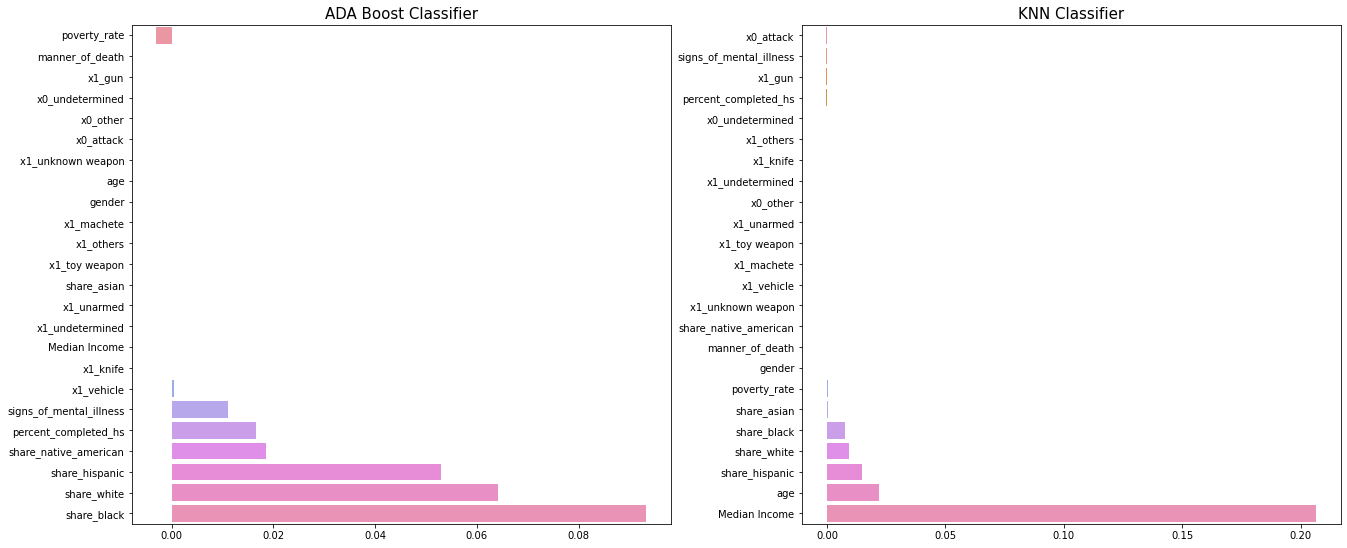

In [ ]:
# KNN Boosting
result = permutation_importance(gridsearch_race_knn.best_estimator_, X_race_train,
                                y_race_train, n_repeats=10, random_state=0)
race_knn_feature_importance = pd.Series(result.importances_mean)
race_knn_feature_importance.index = X_race_train.columns
race_knn_feature_importance = race_knn_feature_importance.sort_values()

# ADA Boost Classifier
result = permutation_importance(gridsearch_race_abc.best_estimator_, X_race_train,
                                y_race_train, n_repeats=10, random_state=0)
race_abc_feature_importance =  pd.Series(result.importances_mean)
race_abc_feature_importance.index = X_race_train.columns
race_abc_feature_importance = race_abc_feature_importance.sort_values()

fig, ax = plt.subplots(1,2, figsize=(20,10))
fig.tight_layout(pad=10)
sns.barplot(ax=ax[0],y=race_abc_feature_importance.index, x=race_abc_feature_importance)
ax[0].set_title('ADA Boost Classifier', fontdict={'fontsize': 15})
sns.barplot(ax=ax[1],y=race_knn_feature_importance.index, x=race_knn_feature_importance)
ax[1].set_title('KNN Classifier', fontdict={'fontsize': 15})

Text(0.5, 1.0, 'Accuracy between KNN and ADABoost')

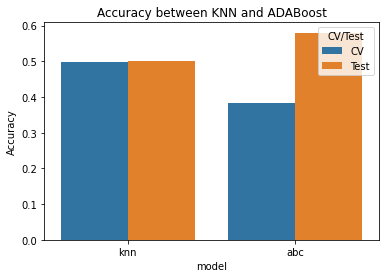

In [ ]:
# accuracy
knn_CV = abs(gridsearch_race_knn.best_score_)
knn_test = abs(gridsearch_race_knn.score(X_race_test, y_race_test))
abc_CV = abs(gridsearch_race_abc.best_score_)
abc_test = abs(gridsearch_race_abc.score(X_race_test, y_race_test))
age_models = pd.DataFrame({'Accuracy': [knn_CV, knn_test, abc_CV, abc_test],
                           'CV/Test':['CV','Test','CV','Test'],
                           'model': ['knn','knn','abc','abc']})
plt.title('Accuracy between KNN and ADABoost')
sns.barplot(x=age_models['model'], y=age_models['Accuracy'], hue=age_models['CV/Test'])